# Introduction to Gradient and Automatic differentiation

In [2]:
#setup
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Gradient tapes
TensorFlow provides the `tf.GradientTape` API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variables`. TensorFlow __"records"__ relevant operations executed inside the context of a `tf.GradientTape` onto a __"tape"__. TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

In [16]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y = x**2

- `tape.gradient(y, x)` computes the gradient descent of `y` over/with respect to `x`
- that is to say, gradient tells us how the value of a y changes as the value of x changes.
    - the gradient is positive for uphill ascent
    - the gradient is negative for downhil descent
    - the gradient value is zero for a minima or a maxima
    - the gradient is larger for steaper ascent/descent
    - the gradient is smaller for laid down ascent/descent
- the value of dy/dx for a given x tells the gradient at the given input x.

In [17]:
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

The above example uses scalars, but tf.GradientTape works as easily on any tensor:

In [21]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

In [22]:
[d1_dw, d1_db] = tape.gradient(loss, [w, b])

print(d1_dw.numpy())
print(d1_db.numpy())

[[ -1.616528  -3.399956]
 [ -3.233056  -6.799912]
 [ -4.849584 -10.199868]]
[-1.616528 -3.399956]


In [23]:
print(w.shape)

(3, 2)


In [24]:
print(d1_dw.shape)

(3, 2)


In [25]:
print(b.shape)
print(d1_db.shape)

(2,)
(2,)


In [26]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.616528, -3.399956], dtype=float32)>

## Gradient with respect to a model 

It's common to collect `tf.Variables` into a `tf.Module` or one of its subclasses (`layers.Layer`, `keras.Model`) for _checkpointing_ and _exporting_.

all subclasses of `tf.Module` aggregate their variables in the `Module.trainable_variables`

In [34]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[3., 5., 1.]])

with tf.GradientTape() as tape:
    y = layer(x)
    loss = tf.reduce_mean(y**2)

grads = tape.gradient(loss, layer.variables)

In [38]:
for var, g in zip(layer.trainable_variables, grads):
  print(f'{var.name}, shape: {g.shape}')

dense_5/kernel:0, shape: (3, 2)
dense_5/bias:0, shape: (2,)


##  Controlling what the tape watches

- The tape needs to watch every operation in the forward pass in order to register all the neccessary operations for backpropagation.
- The tape also holds references to the intermediate operations

In [39]:
#the following case will fail (give None gradient) because x_1 is set to be `untrainable` while x_3 is not watched
# a trainable variable
x_0 = tf.Variable(3., name='x0')

# variable not trainable
x_1 = tf.Variable(4., name='x1', trainable=False)

# not a variable: variable+tensor/scaler returns a tensor
x_2 = tf.Variable(1., name='x2') + 1.0

# not a variable
x_3 = tf.constant(0., name='x3')

with tf.GradientTape() as tape:
    y = (x_0**2) + x_1**2 + x_2**2

grad = tape.gradient(y, [x_0, x_1, x_2, x_3])


In [40]:
for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


In [42]:
# Variables watched by the tape can be listed by using watched_variables function
[var.name for var in tape.watched_variables()]

['x0:0']

In [46]:
# users can control what the tape can watch using the `watch` hook provided in the GradientTape

x = tf.constant(3., name='x')
with tf.GradientTape() as tape:
    tape.watch(x) #let the tape watch the constant
    y = x**2

print(tape.gradient(y, x).numpy())
print([var for var in tape.watched_variables()]) #since x is not a variable it is NOT shown in this list

6.0
[]


In [57]:
# default behaviour of watching all variables could be turned off
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1) #only x_0 is set to be watched: x_1 will not be watched by the tape
    y0 = tf.math.sin(x0)
    y1 = tf.nn.softplus(x1)
    y = y0 + y1
    ys = tf.reduce_sum(y)
    
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


## Intermediate results

In [78]:
x = tf.constant(3.0)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = x**2
    z = y**2
#computing the gradient of z with respect to the intermediat y

tape.gradient(z, y)

<tf.Tensor: shape=(), dtype=float32, numpy=18.0>

In [79]:
#gradient of y with respect to x
tape.gradient(y, x)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [81]:
#gradient of z with respect to x=
tape.gradient(z, x)

<tf.Tensor: shape=(), dtype=float32, numpy=108.0>

In [82]:
del tape #manually release the resources held by the GradientTape

## Gradients of Non-Scalers
- A gradient is fundamentally an operation on a scaler

In [83]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(y0)
print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


Thus, if you ask for the gradient of multiple targets, the result for each source is:

The gradient of the sum of the targets, or equivalently
The sum of the gradients of each target.

In [84]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


Similarly, if the target(s) are not scalar the gradient of the sum is calculated:

In [85]:
x = tf.Variable(2.)
with tf.GradientTape() as tape:
    y = x ** [3., 4.]
print(tape.gradient(y, x).numpy())

44.0


This makes it simple to take the gradient of the sum of a collection of losses, or the gradient of the sum of an element-wise loss calculation.

In [86]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

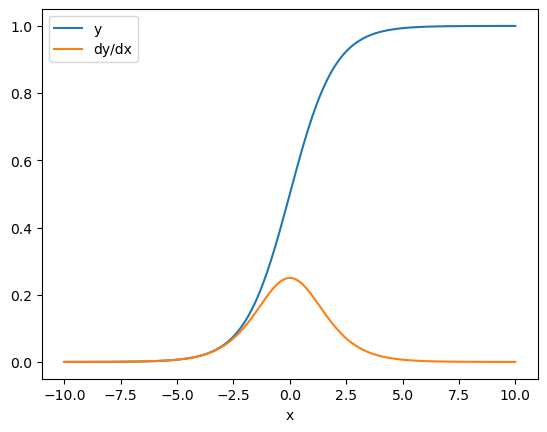

In [87]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## Cases where gradient returns None

- When a target is not connected to a source, gradient will return None.

In [88]:
x = tf.Variable(7.)
y = tf.Variable(1.)

with tf.GradientTape() as tape:
    z = y**2

print(tape.gradient(z, x)) # z(target) is not connected to the source(x) 

None


- Replaced a variable with a tensor

In [90]:
x = tf.Variable(7.)

for epoch in range(3):
    with tf.GradientTape() as tape:
        y = x+1
    
    print(type(x).__name__, ':', tape.gradient(y, x))
    x = x+1 #should be x.assign_add(1)
    # in an attempt to update the value of the variable x, it is no longer a tf.Variable thus not visible to tape
    
    

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None
EagerTensor : None


- Did calculations outside of TensorFlow
    
    The tape can't record the gradient path if the calculation exits TensorFlow. For example:

In [91]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


- Took gradients through an integer or string

Integers and strings are not differentiable. If a calculation path uses these data types there will be no gradient.

Nobody expects strings to be differentiable, but it's easy to accidentally create an int constant or variable if you don't specify the dtype.


In [92]:
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


Took gradients through a stateful object

State stops gradients. When you read from a stateful object, the tape can only observe the current state, not the history that lead to it.
A `tf.Tensor` is immutable. You can't change a tensor once it's created. It has a value, but no state. All the operations discussed so far are also stateless: the output of a `tf.matmul` only depends on its inputs.

A `tf.Variable` has internal state — its value. When you use the variable, the state is read. It's normal to calculate a gradient with respect to a variable, but the variable's state blocks gradient calculations from going farther back. For example:

In [93]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  x1.assign_add(x0)
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

None


In [96]:
# This is how the above situation could be remedies
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
    x1 = x1 + x0
    y = x1**2   # y = (x1 + x0)**2

# This works.
print(tape.gradient(y, x0).numpy())   #dy/dx0 = 2*(x1 + x0)

6.0


## No gradient registered 

Some `tf.Operations` are registered as being non-differentiable and will return `None`. Others have no gradient registered.

The `tf.raw_ops` page shows which low-level ops have gradients registered.

If you attempt to take a gradient through a `float` op that has no gradient registered the tape will throw an error instead of silently returning `None`. This way you know something has gone wrong.

For example, the `tf.image.adjust_contrast` function wraps `raw_ops.AdjustContrastv2`, which could have a gradient but the gradient is not implemented:

In [98]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')

LookupError: gradient registry has no entry for: AdjustContrastv2


If you need to differentiate through this op, you'll either need to implement the gradient and register it (using tf.RegisterGradient) or re-implement the function using other ops.

## Zeros instead of None
In some cases it would be convenient to get 0 instead of None for unconnected gradients. You can decide what to return when you have unconnected gradients using the `unconnected_gradients` argument:

In [103]:
x = tf.Variable(2.)
y = tf.Variable(6.)

with tf.GradientTape() as tape:
    z = y**2

print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO).numpy())

0.0
